# Got Raps?

## Background

I am someone who *loves* to music. One of my favorite genres to listen to is hip-hop/rap because of, in some cases, the focus on lyricism. 

In recent years, there has been less of a focus in this regard, leading some fans of "true hip-hop" to look down upon the musicians currently in the spotlight. Part of the criticism of modern rap is how forgettable the lyrics and songs are due to their simplistic nature. 

While learning about *recurrent neural networks* (RNNs)I came across a [video](https://www.youtube.com/watch?v=ZMudJXhsUpY) by Laurence Moroney explaining how AI can be used to generate poetry after training upon a corpus of Irish poems. This sparked an idea to try and do the same with a modern song lyrics. I specifically decided to choose rap because of my familiarity with the genre and thinking that the songs may have more words since the artists are not singing (most of the time).

I will be scraping lyrics from [azlyrics](https://www.azlyrics.com/t/tyga.html) using BeautifulSoup and Keras to create my RNN.

supplemental site https://www.allthelyrics.com/lyrics/tyga
alternative https://www.lyricsbox.com/tyga-lyrics-hdgvd.html

**Subsitute Cuss Words With Nonsensical Words OR Censor Words As-Is**

**Blog post about non-contiguous bigrams?** [Link](https://www.frontiersin.org/articles/10.3389/fpsyg.2011.00136/full)

# Imports

#### Packages

In [3]:
import os
import requests
import regex
import pickle
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import functions as dlf
import matplotlib.pyplot as plt
import nltk.corpus as nltkcorpus
import nltk.collocations as collc
from bs4 import BeautifulSoup
from nltk import word_tokenize, FreqDist
from nltk.stem import PorterStemmer
from importlib import reload

#### Pickles

###### For Notebook

In [4]:
#### WRITING ATLs ####
# with open('Pickles/song_dict.pickle', 'wb') as f:
#     pickle.dump(song_dict, f)
#     f.close()

#### READING ATLs ####
with open('Pickles/song_dict.pickle', 'rb') as f:
    song_dict = pickle.load(f)
    f.close()
del song_dict['B.M.F.'], song_dict['Birdman Interlude']

#### WRITING AZLYRICS ####
# with open('Pickles/album_dict.pickle', 'wb') as f:
#     pickle.dump(album_dict, f)
#     f.close()

#### READING AZLYRICS ####
# with open('Pickles/album_dict.pickle', 'rb') as f:
#     album_dict = pickle.load(f)
#     f.close()

#### WRITING TOKENIZED LYRICS ####
# with open('Pickles/tokenized_lyrics.pickle', 'wb') as f:
#     pickle.dump(tokenized_lyrics, f)
#     f.close()
    
#### READING TOKENIZED LYRICS ####
with open('Pickles/tokenized_lyrics.pickle', 'rb') as f:
    tokenized_lyrics = pickle.load(f)
    f.close()
    
#### WRITING CLEANED LYRICS ####
# with open('Pickles/cleaned_lyrics.pickle', 'wb') as f:
#     pickle.dump(cleaned_lyrics, f)
#     f.close()
    
#### READING CLEANED LYRICS ####
with open('Pickles/cleaned_lyrics.pickle', 'rb') as f:
    cleaned_lyrics = pickle.load(f)
    f.close()
    
#### WRITING CLEANED LYRICS AS SINGLE STRING ####
# with open('Pickles/cleaned_lyrics_string.pickle', 'wb') as f:
#     pickle.dump(cleaned_lyrics_string, f)
#     f.close()
    
#### READING CLEANED LYRICS AS SINGLE STRING ####
with open('Pickles/cleaned_lyrics_string.pickle', 'rb') as f:
    cleaned_lyrics_string = pickle.load(f)
    f.close()

#### WRITING CLEANED LYRICS w/FTS ####
# with open('Pickles/cleaned_lyrics_fts.pickle', 'wb') as f:
#     pickle.dump(cleaned_lyrics_fts, f)
#     f.close()
    
#### READING CLEANED LYRICS w/FTS ####
with open('Pickles/cleaned_lyrics_fts.pickle', 'rb') as f:
    cleaned_lyrics_fts = pickle.load(f)
    f.close()

#### WRITING CLEANED LYRICS w/FTS AS SINGLE STRING ####
# with open('Pickles/cleaned_lyrics_string_fts.pickle', 'wb') as f:
#     pickle.dump(cleaned_lyrics_string_fts, f)
#     f.close()
    
#### READING CLEANED LYRICS w/FTS AS SINGLE STRING ####
with open('Pickles/cleaned_lyrics_string_fts.pickle', 'rb') as f:
    cleaned_lyrics_string_fts = pickle.load(f)
    f.close()

###### For App

In [25]:
#### WRITING IDX_V_CHAR w/FTS ####
# with open('Pickles/idx_v_char_fts.pickle', 'wb') as f:
#     pickle.dump(idx_v_char_fts, f)
#     f.close()
    
#### READING IDX_V_CHAR w/FTS ####
# with open('Pickles/idx_v_char_fts.pickle', 'rb') as f:
#     idx_v_char_fts = pickle.load(f)
#     f.close()

#### WRITING CHAR_V_IDX w/FTS ####
# with open('Pickles/char_v_idx_fts.pickle', 'wb') as f:
#     pickle.dump(char_v_idx_fts, f)
#     f.close()
    
#### READING CHAR_V_IDX w/FTS ####
# with open('Pickles/char_v_idx_fts.pickle', 'rb') as f:
#     char_v_idx_fts = pickle.load(f)
#     f.close()

#### WRITING MODEL_GEN w/FTS ####
# with open('Pickles/model_gen_fts.pickle', 'wb') as f:
#     pickle.dump(model_gen_fts, f)
#     f.close()
    
#### READING MODEL_GEN w/FTS ####
# with open('Pickles/model_gen_fts.pickle', 'rb') as f:
#     model_gen_fts = pickle.load(f)
#     f.close()

#### Functions

###### Modeling

In [8]:
## Helper function to create inputs and targets
def split_input_target(chunk):
    ## https://www.tensorflow.org/tutorials/text/text_generation
    
    input_text = chunk[:-1]
    target_text = chunk[1:]
    
    return input_text, target_text

In [9]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    ## Initial structure provided by:
    ## https://www.tensorflow.org/tutorials/text/text_generation#build_the_model
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [10]:
## Defining loss function to be optimized during training
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [18]:
def generate_text(model, char_v_idx_, idx_v_char_, start_string, num_chars=100, temp=1.0):
    # https://www.tensorflow.org/tutorials/text/text_generation#the_prediction_loop
    
    ## Evaluation step (generating text using the learned model)

    ## Number of characters to generate
    num_generate = num_chars

    ## Converting our start string to numbers (vectorizing)
    input_eval = [char_v_idx_[s] for s in start_string.lower()]
    input_eval = tf.expand_dims(input_eval, 0)

    ## Empty string to store our results
    text_generated = []

    ## Low temperature results in more predictable text.
    ## Higher temperature results in more surprising text.
    ## Experiment to find the best setting.
    temperature = temp

    ## Here batch size == 1
    model.reset_states()
    
    for i in range(num_generate):
        predictions = model(input_eval)
        ## Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        ## Using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        ## Pass the predicted character as the next input to the model
        ## along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx_v_char_[predicted_id])

    return (start_string + ''.join(text_generated))

###### App

Due to a quirk in the source code, the Tensorflow models are unable to be pickled. These functions make that possible by modifying the `Model` class itself. [Click here](https://github.com/tensorflow/tensorflow/issues/34697) for source material.

In [21]:
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.models import Model

## https://github.com/tensorflow/tensorflow/issues/34697
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

In [23]:
# Run the function
make_keras_picklable()

# Data Collection + EDA

## Getting Soupy

#### Connecting

In [ ]:
## Starting page + Q.C. of response
# start_url = 'https://www.azlyrics.com/t/tyga.html'  ## Banned
# start_url = 'https://www.lyricsbox.com/tyga-lyrics-hdgvd.html' ## Doesn't work

In [2]:
## Starting page + Q.C. of response
start_url = 'https://www.allthelyrics.com/lyrics/tyga'
start_resp = requests.get(start_url)
print(f'Starting Response: {start_resp}')

Starting Response: <Response [200]>


#### Main Page Soup

In [3]:
## Creating soup + Q.C.
start_soup = BeautifulSoup(start_resp.text, 'html.parser')
print(start_soup.prettify()[13900:14500])

            TYGA lyrics: 'Never Be The Same', 'Hookah (feat. Young Thug)', 'Riot (feat. Honey Cocaine)', 'Make It Nasty', 'We Up'
              </div>
              <div class="content-top-lyricspopular">
               <div class="artist-lyrics-list artist-lyrics-list-popular">
                <h2 class="artist-lyrics-list-h2">
                 Top 5 songs
                </h2>
                <ol>
                 <li class="lyrics-list-item lyrics-list-item-1737736">
                  <a href="/lyrics/tyga-never_be_the_same">
                   Never Be The Same
                  </a>
     


#### Collecting Song Links + Names

In [ ]:
## Create container for names/links + find links ('a') in soup
song_dict = {}
link_list = start_soup.findAll('a')

## Select and store links to Tyga songs
for a in link_list:
    if '/lyrics/tyga-' in a['href']:
        song_dict[a.text] = a['href']

## Q.C.
display(song_dict)

In [3]:
## Create iterable with song names for operations
song_names = list(song_dict.keys())

#### Collecting Lyrics - Test

In [4]:
#### Testing strategy for lyric removal ####

## Join strings to create full song URL
end_url = song_dict['Hookah (feat. Young Thug)']
start_url = 'https://www.allthelyrics.com'
full_url = start_url + end_url

## Generating soup
# song_resp = requests.get(full_url)
song_soup = BeautifulSoup(song_resp.text, 'html.parser')

## Q.C. + HTML structure info
print("Example of target 'div' and section names:\n")
print(song_soup.prettify()[12110:12210], '\n\t...')
print(song_soup.prettify()[13823:14000])

## Collect lyrics 'div' from song soup as a bs4 tag + store in song dict
lyrics = song_soup.findAll('div', attrs={'class': 'content-text-inner'}).pop()

song_dict['Hookah (feat. Young Thug)'] = lyrics

Example of target 'div' and section names:

       <div class="content-text-inner">
              <p>
               [Hook x4 - Young Thug:]
    
	...
               [Verse 2 - Tyga:]
               <br/>
               Rubbin on my chain blowing cloudmatic
               <br/>
               Smoke something with a G and bend 


#### Collecting Lyrics

In [29]:
## Iteratively scrape 5 songs at a time
dlf.song_scraper(song_dict, song_names, limit=5, verbose=False)

----------------------------------------
Song to be scraped: B.M.F.
Something wrong with link for B.M.F.
----------------------------------------
Song to be scraped: Young Kobe
Sleeping 196.45 seconds...
Ding!
----------------------------------------
Total number of songs skipped: 181


In [30]:
## Get update on how many songs scraped successfully
dlf.song_scraping_stats(song_dict)

{'tag': 182, 'string': 1}

> For ease, I am going to remove the 'B.M.F' song from this dictionary so that I can easily make a function for the entire dictionary. 

In [32]:
## Removing the broken link
song_dict.pop('B.M.F.', None)

'/lyrics/tyga-b.m.f.'

## Lyric Conversion

Before I get into the removal of non-Tyga lyrics, I want to first get them represented as a string (or strings) in hopes of making the code simpler. This is because as-is there are two different types of BeautifulSoup elements in the lyrics: `<class 'bs4.element.NavigableString'>` and `<class 'bs4.element.Tag'>`; the latter containing a .text attribute while the former does not.

## Lyric Filtering

In [100]:
## Setting containers for titles
songs_with_ft = []
songs_solo = []

## Separate and store song titles
for key in song_dict:
    if ('(feat.' in key) | ('(with' in key):
        songs_with_ft.append(key)
    else:
        songs_solo.append(key)

## Optional Q.C.
# for title in songs_with_ft:
#     title_res = regex.findall(r'\((feat..+|with.+)\)', title)
#     print(title_res)

In [101]:
## Container for lyrics
dict_no_ft = {}

## Storing lyrics of selected songs from main dict
for title in songs_solo:
    ## T/E display for handling edge cases
    try:
        dict_no_ft[title] = song_dict[title]
    except:
        print(title)

## Collecting ordered list of all lyric headers
no_feat_headers = dlf.lyric_header_checker(dict_no_ft, display_multi=False)

## Targeting droppable headers learned from 'no_feat_headers'
drop_headers = ['[Chorus: Patty Cash]', '[Chorus: Patrick Stump]', '[Birdman]',
                '[Outro: Tyga’s Mother]', '[Outro: Martin Luther King Jr.]',
                '[Verse 2: 2Chainz]', '[Patrick Stump:]',
                '[Chorus x2: Patrick Stump]', '[Gator:]', '[Hook: Quavo]',
                '[Intro: DJ Drama talking]']

## Filtering
filtered_lyrics = dlf.lyric_header_filter(dict_no_ft, drop_headers, display_multi=False)

## Q.C.
filtered_lyrics['Do It All'][0]

'[Verse 1]\nLooking at the ceiling thinking why I treat you bad\nAin’t no worser feelings than knowing I did it for the last\nArguing, all I was doing accusing you, my bad\nSaid “Let’s take some time”, nevermind, rewind\nLooking at the ceiling thinking why I treat you bad\nAin’t no worser feelings than knowing I did it for the last\nArguing, all I was doing accusing you, my bad\nSaid “Let’s take some time”, nevermind, just playing with your mind\nI always thought “play dumb”, and let the other one love\nWhy? Get caught up in nowhere but trust\nOnly love for fun, I’m too young, I thought\nAll I wanted was a thanks to Louboutins I bought\nBut it ain’t your fault; heaven knows you deserve it all\nYou sent letters to my heart, but I burned them all\nThe Bible says before you run, gotta learn to crawl\nBut I don’t wanna waste time if we ain’t involved'

## Lyric Tokenizing

In [102]:
## Merging lyrics + Q.C.
merged_lyrics = dlf.lyric_line_splitter(filtered_lyrics)
merged_lyrics['Do It All'][0:17]

['[Verse 1]',
 'Looking at the ceiling thinking why I treat you bad',
 'Ain’t no worser feelings than knowing I did it for the last',
 'Arguing, all I was doing accusing you, my bad',
 'Said “Let’s take some time”, nevermind, rewind',
 'Looking at the ceiling thinking why I treat you bad',
 'Ain’t no worser feelings than knowing I did it for the last',
 'Arguing, all I was doing accusing you, my bad',
 'Said “Let’s take some time”, nevermind, just playing with your mind',
 'I always thought “play dumb”, and let the other one love',
 'Why? Get caught up in nowhere but trust',
 'Only love for fun, I’m too young, I thought',
 'All I wanted was a thanks to Louboutins I bought',
 'But it ain’t your fault; heaven knows you deserve it all',
 'You sent letters to my heart, but I burned them all',
 'The Bible says before you run, gotta learn to crawl',
 'But I don’t wanna waste time if we ain’t involved']

In [103]:
## Cleaning punctuation/headers + lowering strings + Q.C.
cleaned_lyrics = dlf.song_cleaner(merged_lyrics)
cleaned_lyrics['Do It All'][0:16]

['looking at the ceiling thinking why i treat you bad',
 'aint no worser feelings than knowing i did it for the last',
 'arguing all i was doing accusing you my bad',
 'said lets take some time nevermind rewind',
 'looking at the ceiling thinking why i treat you bad',
 'aint no worser feelings than knowing i did it for the last',
 'arguing all i was doing accusing you my bad',
 'said lets take some time nevermind just playing with your mind',
 'i always thought play dumb and let the other one love',
 'why get caught up in nowhere but trust',
 'only love for fun im too young i thought',
 'all i wanted was a thanks to louboutins i bought',
 'but it aint your fault heaven knows you deserve it all',
 'you sent letters to my heart but i burned them all',
 'the bible says before you run gotta learn to crawl',
 'but i dont wanna waste time if we aint involved']

In [26]:
## Tokenizing lyrics
tokenized_lyrics = dlf.lyric_tokenizer(cleaned_lyrics)
tokenized_lyrics['Do It All'][0:16]

['looking',
 'at',
 'the',
 'ceiling',
 'thinking',
 'why',
 'i',
 'treat',
 'you',
 'bad',
 'aint',
 'no',
 'worser',
 'feelings',
 'than',
 'knowing']

## Token Exploration

#### Rack City Visuals

In [60]:
test_fdist = pd.Series(dict(FreqDist(tokenized_lyrics['Rack City (Single Version)'])))

In [48]:
test_fdist.values

array([35, 20, 35,  1,  5,  8,  1,  1, 27,  9,  1,  1,  1,  1,  1,  2,  1,
        1,  1,  5,  2,  3,  1,  3,  2,  5,  8,  2,  2,  1,  3,  2,  3,  1,
        2,  5,  1,  5,  1,  2,  1,  1,  1,  1,  4,  2,  1,  1,  1,  1,  1,
        1,  1,  2,  3,  2,  1,  1,  1,  1,  1,  2,  1,  2,  2,  8,  8,  8,
        2,  2,  1,  2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  2,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,
        2,  1,  1,  1,  1,  1,  1,  9, 36], dtype=int64)

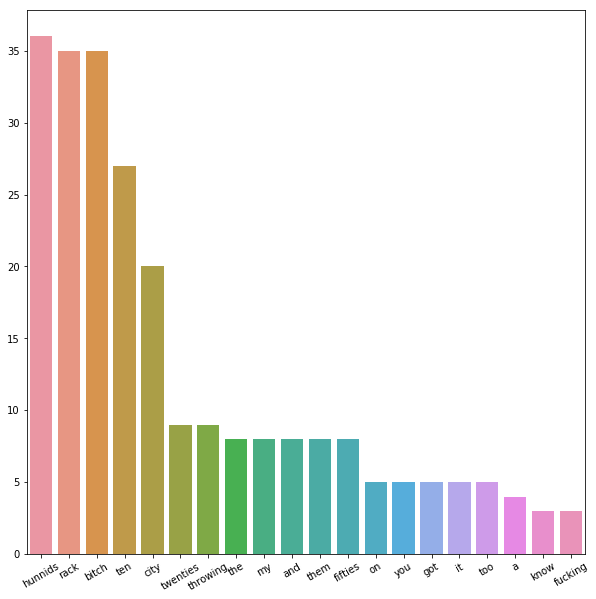

In [54]:
fig, ax = plt.subplots(figsize=(10,10))

test_plot = sns.barplot(x=test_fdist.index, y=test_fdist.values, ax=ax)
plt.xticks(rotation=30);

In [67]:
total_words = test_fdist.values.sum()
test_fdist_df = pd.DataFrame(test_fdist)
test_fdist_df.columns = ['num_uses']
test_fdist_df['percent_of_total'] = test_fdist_df['num_uses'] / total_words
test_percent_plot = test_fdist_df['percent_of_total'].sort_values(ascending=False).head(20).copy()
test_percent_plot

hunnids     0.093264
bitch       0.090674
rack        0.090674
ten         0.069948
city        0.051813
twenties    0.023316
throwing    0.023316
fifties     0.020725
them        0.020725
my          0.020725
and         0.020725
the         0.020725
too         0.012953
you         0.012953
got         0.012953
on          0.012953
it          0.012953
a           0.010363
like        0.007772
know        0.007772
Name: percent_of_total, dtype: float64

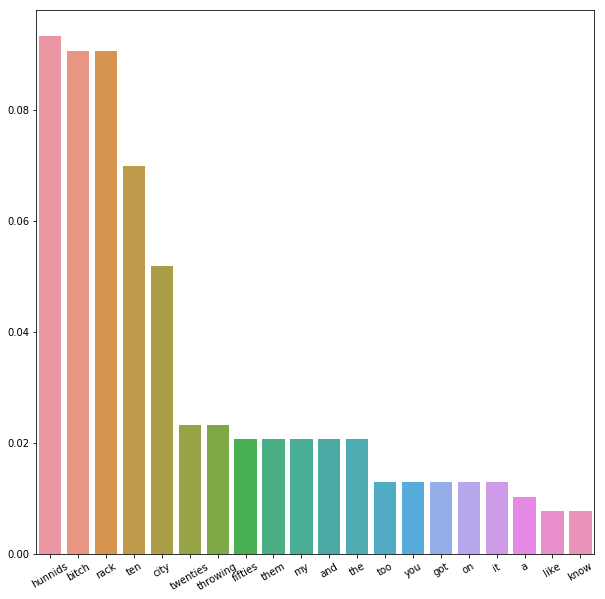

In [68]:
fig, ax = plt.subplots(figsize=(10,10))

test_plot2 = sns.barplot(x=test_percent_plot.index, y=test_percent_plot.values, ax=ax)
plt.xticks(rotation=30);

##### Bigrams

In [70]:
bigram_measures = collc.BigramAssocMeasures()
bigram_finder = collc.BigramCollocationFinder.from_words(tokenized_lyrics['Rack City (Single Version)'])
bigram_scored = bigram_finder.score_ngrams(bigram_measures.raw_freq)
bigram_scored[:50]

[(('hunnids', 'hunnids'), 0.06217616580310881),
 (('city', 'bitch'), 0.05181347150259067),
 (('ten', 'ten'), 0.046632124352331605),
 (('rack', 'city'), 0.04404145077720207),
 (('rack', 'rack'), 0.04404145077720207),
 (('bitch', 'rack'), 0.025906735751295335),
 (('ten', 'twenties'), 0.023316062176165803),
 (('throwing', 'hunnids'), 0.023316062176165803),
 (('and', 'them'), 0.02072538860103627),
 (('fifties', 'bitch'), 0.02072538860103627),
 (('them', 'fifties'), 0.02072538860103627),
 (('twenties', 'and'), 0.02072538860103627),
 (('bitch', 'ten'), 0.018134715025906734),
 (('hunnids', 'rack'), 0.015544041450777202),
 (('hunnids', 'throwing'), 0.015544041450777202),
 (('bitch', 'city'), 0.007772020725388601),
 (('bitch', 'hunnids'), 0.007772020725388601),
 (('bitch', 'throwing'), 0.007772020725388601),
 (('got', 'my'), 0.007772020725388601),
 (('a', 'motherfucking'), 0.0051813471502590676),
 (('bitch', 'bitch'), 0.0051813471502590676),
 (('bitch', 'fucking'), 0.0051813471502590676),
 (('f

##### Trigrams

In [28]:
trigram_measures = collc.TrigramAssocMeasures()
trigram_finder = collc.TrigramCollocationFinder.from_words(tokenized_lyrics['Rack City (Single Version)'])
trigram_scored = trigram_finder.score_ngrams(trigram_measures.raw_freq)
trigram_scored[:50]

[(('rack', 'city', 'bitch'), 0.04404145077720207),
 (('hunnids', 'hunnids', 'hunnids'), 0.031088082901554404),
 (('bitch', 'rack', 'rack'), 0.025906735751295335),
 (('city', 'bitch', 'rack'), 0.025906735751295335),
 (('rack', 'rack', 'city'), 0.025906735751295335),
 (('ten', 'ten', 'ten'), 0.023316062176165803),
 (('ten', 'ten', 'twenties'), 0.023316062176165803),
 (('throwing', 'hunnids', 'hunnids'), 0.023316062176165803),
 (('and', 'them', 'fifties'), 0.02072538860103627),
 (('ten', 'twenties', 'and'), 0.02072538860103627),
 (('them', 'fifties', 'bitch'), 0.02072538860103627),
 (('twenties', 'and', 'them'), 0.02072538860103627),
 (('bitch', 'ten', 'ten'), 0.018134715025906734),
 (('hunnids', 'hunnids', 'rack'), 0.015544041450777202),
 (('hunnids', 'hunnids', 'throwing'), 0.015544041450777202),
 (('hunnids', 'rack', 'city'), 0.015544041450777202),
 (('hunnids', 'throwing', 'hunnids'), 0.015544041450777202),
 (('rack', 'rack', 'rack'), 0.015544041450777202),
 (('bitch', 'city', 'bitch'

#### All Solo Tokens Visuals

In [21]:
all_fdist

i        1365
the      1359
a        1020
you       932
it        895
my        865
im        667
in        632
like      630
to        624
me        597
and       480
that      474
dont      470
on        455
all       415
bitch     387
up        373
got       369
she       325
dtype: int64

Total tokens: 45,196
Total unique tokens: 5,235


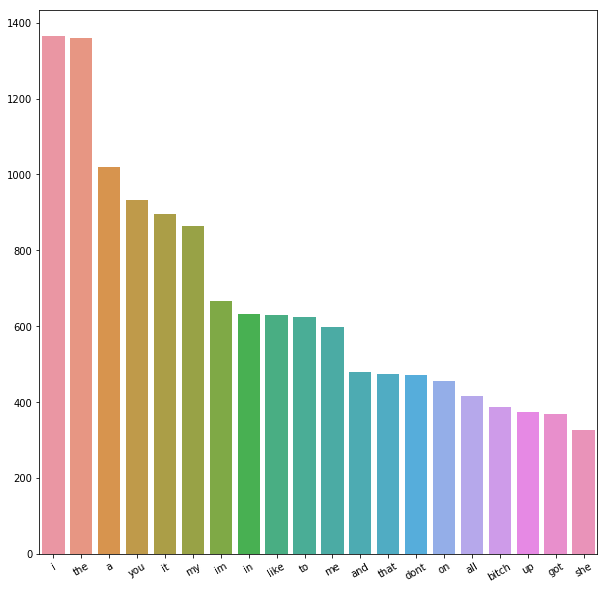

In [3]:
all_song_tokens = []

for song in tokenized_lyrics:
    all_song_tokens.extend(tokenized_lyrics[song])

print(f'Total tokens: {len(all_song_tokens):,}')
print(f'Total unique tokens: {len(set(all_song_tokens)):,}')

all_fdist = pd.Series(dict(FreqDist(all_song_tokens).most_common(20)))

fig, ax = plt.subplots(figsize=(10,10))

all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

In [11]:
total_words_all = all_fdist.values.sum()
all_fdist_df = pd.DataFrame(all_fdist)
all_fdist_df.columns = ['num_uses']
all_fdist_df['percent_of_total'] = all_fdist_df['num_uses'] / total_words_all
all_percent_plot = all_fdist_df['percent_of_total'].sort_values(ascending=False).head(20).copy()
all_percent_plot

i        0.102370
the      0.101920
a        0.076496
you      0.069897
it       0.067122
my       0.064872
im       0.050022
in       0.047398
like     0.047248
to       0.046798
me       0.044773
and      0.035998
that     0.035548
dont     0.035248
on       0.034123
all      0.031123
bitch    0.029024
up       0.027974
got      0.027674
she      0.024374
Name: percent_of_total, dtype: float64

##### Bigrams

In [12]:
bigram_measures_all = collc.BigramAssocMeasures()
bigram_finder_all = collc.BigramCollocationFinder.from_words(all_song_tokens)
bigram_scored_all = bigram_finder_all.score_ngrams(bigram_measures_all.raw_freq)
bigram_scored_all[:50]

[(('in', 'the'), 0.003982653332153288),
 (('make', 'it'), 0.0031197451101867423),
 (('i', 'dont'), 0.003009115850960262),
 (('in', 'my'), 0.0024117178511372686),
 (('like', 'a'), 0.0024117178511372686),
 (('wan', 'na'), 0.0024117178511372686),
 (('got', 'ta'), 0.0023232144437560845),
 (('i', 'aint'), 0.0022789627400654927),
 (('on', 'the'), 0.0022568368882201965),
 (('i', 'got'), 0.0017700681476236835),
 (('to', 'the'), 0.0017700681476236835),
 (('on', 'my'), 0.0016594388883972033),
 (('bitch', 'im'), 0.001526683777325427),
 (('it', 'rain'), 0.001460306221789539),
 (('all', 'my'), 0.001416054518098947),
 (('im', 'a'), 0.0013718028144083546),
 (('it', 'up'), 0.0013054252588724667),
 (('wassup', 'wassup'), 0.0012390477033365785),
 (('im', 'the'), 0.0012169218514912824),
 (('in', 'a'), 0.0011947959996459864),
 (('you', 'know'), 0.0011062925922648021),
 (('the', 'shit'), 0.0010841667404195062),
 (('stop', 'stop'), 0.00106204088857421),
 (('but', 'i'), 0.0010399150367289142),
 (('throw', 'i

##### Trigrams

In [13]:
trigram_measures_all = collc.TrigramAssocMeasures()
trigram_finder_all = collc.TrigramCollocationFinder.from_words(all_song_tokens)
trigram_scored_all = trigram_finder_all.score_ngrams(trigram_measures_all.raw_freq)
trigram_scored_all[:50]

[(('make', 'it', 'rain'), 0.001416054518098947),
 (('stop', 'stop', 'stop'), 0.0007965306664306576),
 (('throw', 'it', 'up'), 0.0007965306664306576),
 (('im', 'the', 'shit'), 0.0007301531108947695),
 (('it', 'rain', 'trick'), 0.0007301531108947695),
 (('its', 'all', 'love'), 0.0007080272590494735),
 (('wassup', 'its', 'all'), 0.0007080272590494735),
 (('love', 'teenage', 'love'), 0.0006637755553588813),
 (('teenage', 'love', 'teenage'), 0.0006637755553588813),
 (('dont', 'wan', 'na'), 0.0006416497035135853),
 (('wan', 'na', 'be'), 0.0006416497035135853),
 (('real', 'or', 'fake'), 0.0006195238516682892),
 (('it', 'make', 'it'), 0.0005973979998229932),
 (('make', 'it', 'make'), 0.0005973979998229932),
 (('i', 'got', 'ta'), 0.0005752721479776971),
 (('rack', 'city', 'bitch'), 0.0005752721479776971),
 (('rain', 'trick', 'make'), 0.0005752721479776971),
 (('trick', 'make', 'it'), 0.0005752721479776971),
 (('it', 'up', 'throw'), 0.0005531462961324011),
 (('up', 'throw', 'it'), 0.000553146296

#### Stopwords Visuals

In [4]:
stopwords = nltkcorpus.stopwords.words('english')
all_song_tokens_stopped = []

for word in all_song_tokens:
    if word in stopwords:
        pass
    else:
        all_song_tokens_stopped.append(word)
        
print(f'Before stopword removal: {len(all_song_tokens):,}')
print(f'After stopword removal: {len(all_song_tokens_stopped):,}')

Before stopword removal: 45,196
After stopword removal: 27,141


##### Bigrams

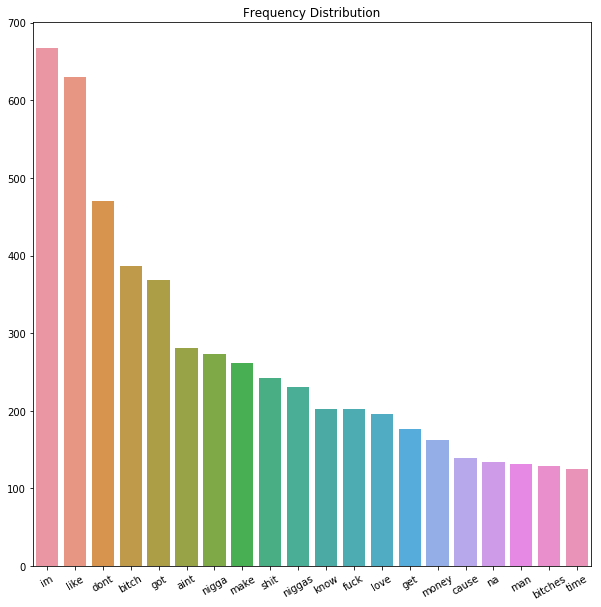

********************
Top 20 tokens usage rate (%):
********************


im         0.123313
like       0.116473
dont       0.086892
bitch      0.071547
got        0.068220
aint       0.051950
nigga      0.050471
make       0.048438
shit       0.044740
niggas     0.042522
know       0.037345
fuck       0.037345
love       0.036236
get        0.032723
money      0.029950
cause      0.025698
na         0.024774
man        0.024404
bitches    0.023849
time       0.023110
Name: Ratio, dtype: float64

Top 20 Bi-grams by frequency


[(('wan', 'na'), 0.004016064257028112),
 (('got', 'ta'), 0.003868685752183044),
 (('bitch', 'im'), 0.002542279208577429),
 (('make', 'rain'), 0.002431745329943628),
 (('wassup', 'wassup'), 0.0020632990678309568),
 (('stop', 'stop'), 0.0017685420581408202),
 (('aint', 'got'), 0.0014369404222394164),
 (('teenage', 'love'), 0.0013632511698168821),
 (('dont', 'know'), 0.0013264065436056152),
 (('im', 'shit'), 0.0013264065436056152),
 (('well', 'done'), 0.0012527172911830809),
 (('rain', 'trick'), 0.001215872664971814),
 (('city', 'bitch'), 0.0011790280387605468),
 (('hunnids', 'hunnids'), 0.0011790280387605468),
 (('wassup', 'love'), 0.0011790280387605468),
 (('love', 'teenage'), 0.0011053387863380127),
 (('dont', 'wan'), 0.0010684941601267455),
 (('make', 'make'), 0.0010684941601267455),
 (('real', 'fake'), 0.0010684941601267455),
 (('ten', 'ten'), 0.0010316495339154784)]

PMI score for 20 Bi-grams


[(('ahead', 'vent'), 13.728186256845007),
 (('alonzo', 'rondo'), 13.728186256845007),
 (('ambulance', 'firetruck'), 13.728186256845007),
 (('betty', 'boop'), 13.728186256845007),
 (('estate', 'boppers'), 13.728186256845007),
 (('excuse', 'manners'), 13.728186256845007),
 (('ford', 'escort'), 13.728186256845007),
 (('hero', 'heads'), 13.728186256845007),
 (('hors', 'doeuvres'), 13.728186256845007),
 (('jealously', 'attracting'), 13.728186256845007),
 (('katy', 'perry'), 13.728186256845007),
 (('metal', 'spoon'), 13.728186256845007),
 (('officer', 'autograph'), 13.728186256845007),
 (('pledge', 'allegiance'), 13.728186256845007),
 (('pun', 'intended'), 13.728186256845007),
 (('scottie', 'pippen'), 13.728186256845007),
 (('sin', 'jealously'), 13.728186256845007),
 (('skatin', 'basement'), 13.728186256845007),
 (('splurging', 'urgently'), 13.728186256845007),
 (('titles', 'cuffing'), 13.728186256845007)]

In [15]:
dlf.token_stat_generator(all_song_tokens_stopped, fd_plot=True, fd_show_ratio=True, ngram=True, n=2, ngram_freq_filter=2, ngram_pmi=True)

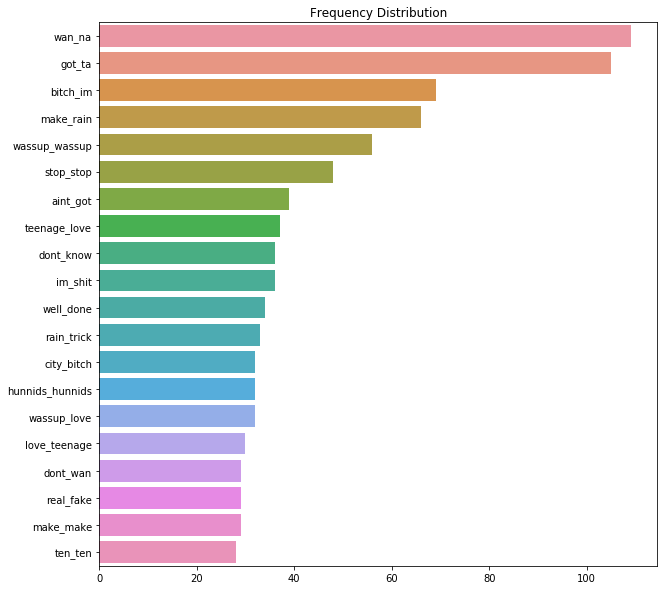

In [52]:
stopped_bigrams = dlf.n_gram_creator(all_song_tokens_stopped, counts=True)
stopped_bigrams_joined = dlf.n_gram_plot_prepper(stopped_bigrams, keep='join')
dlf.freqdist_plotter(stopped_bigrams_joined, premade_fd=True, h_plot=True, n_common=20)

##### Trigrams

In [16]:
dlf.token_stat_generator(all_song_tokens_stopped, fd_plot=False, ngram=True, n=3, ngram_freq_filter=2, ngram_pmi=True)

Top 20 Tri-grams by frequency


[(('stop', 'stop', 'stop'), 0.0013264065436056152),
 (('make', 'rain', 'trick'), 0.001215872664971814),
 (('love', 'teenage', 'love'), 0.0011053387863380127),
 (('teenage', 'love', 'teenage'), 0.0011053387863380127),
 (('dont', 'wan', 'na'), 0.0010684941601267455),
 (('rack', 'city', 'bitch'), 0.0009579602814929443),
 (('rain', 'trick', 'make'), 0.0009579602814929443),
 (('wassup', 'wassup', 'love'), 0.0008842710290704101),
 (('wassup', 'wassup', 'wassup'), 0.0008842710290704101),
 (('aint', 'got', 'ta'), 0.000847426402859143),
 (('im', 'make', 'rain'), 0.0008105817766478759),
 (('bitch', 'im', 'bitch'), 0.0007737371504366088),
 (('im', 'bitch', 'im'), 0.0007737371504366088),
 (('make', 'make', 'rain'), 0.0007000478980140746),
 (('ballin', 'ballin', 'ballin'), 0.0006632032718028076),
 (('got', 'ta', 'super'), 0.0006632032718028076),
 (('party', 'party', 'party'), 0.0006632032718028076),
 (('ta', 'super', 'size'), 0.0006632032718028076),
 (('take', 'look', 'around'), 0.00066320327180280

PMI score for 20 Tri-grams


[(('sin', 'jealously', 'attracting'), 27.456372513690017),
 (('trending', 'topic', 'hermès'), 27.456372513690017),
 (('urge', 'ultimately', 'adult'), 27.456372513690017),
 (('biggie', 'pun', 'intended'), 26.87141001296886),
 (('flabbergastin', 'spazz', 'spasm'), 26.87141001296886),
 (('hors', 'doeuvres', 'buying'), 26.87141001296886),
 (('pyramids', 'homicide', 'descriptions'), 26.87141001296886),
 (('zippin', 'dippin', 'jabs'), 26.87141001296886),
 (('add', 'titles', 'cuffing'), 26.456372513690017),
 (('biggest', 'sin', 'jealously'), 26.456372513690017),
 (('choo', 'train', 'oww'), 26.456372513690017),
 (('forward', 'ford', 'escort'), 26.456372513690017),
 (('rushing', 'add', 'titles'), 26.456372513690017),
 (('womens', 'lives', 'classy'), 26.456372513690017),
 (('cum', 'flabbergastin', 'spazz'), 26.286447512247705),
 (('dracula', 'casket', 'matters'), 26.286447512247705),
 (('mathematics', 'animal', 'dracula'), 26.286447512247705),
 (('pouring', 'champaign', 'chilling'), 26.286447512

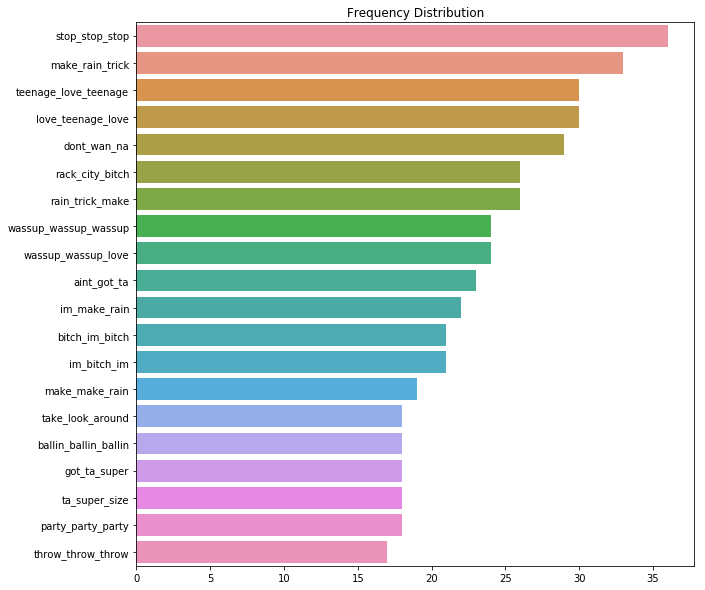

In [55]:
stopped_trigrams = dlf.n_gram_creator(all_song_tokens_stopped, n=3, counts=True)
stopped_trigrams_joined = dlf.n_gram_plot_prepper(stopped_trigrams, keep='join')
dlf.freqdist_plotter(stopped_trigrams_joined, premade_fd=True, h_plot=True, n_common=20)

#### Stemming Visuals

In [5]:
stemmer = PorterStemmer()
all_song_tokens_stemmed = []

for token in all_song_tokens_stopped:
    word = stemmer.stem(token)
    all_song_tokens_stemmed.append(word)

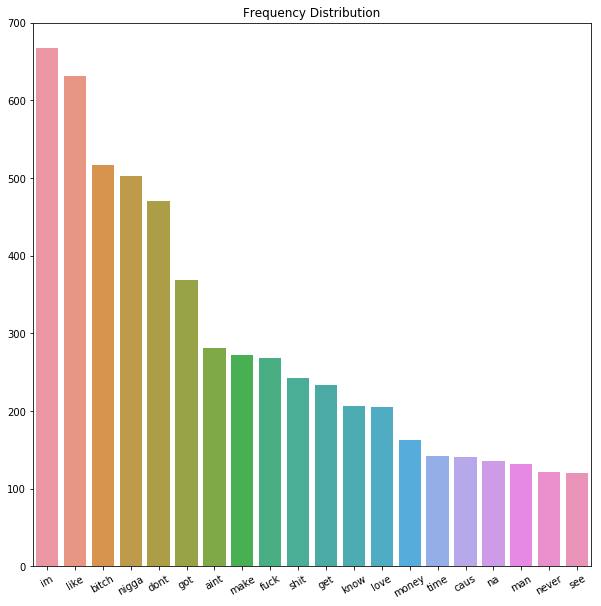

********************
Top 20 tokens usage rate (%):
********************


im       0.114625
like     0.108438
bitch    0.088847
nigga    0.086441
dont     0.080770
got      0.063413
aint     0.048290
make     0.046743
fuck     0.046056
shit     0.041760
get      0.040213
know     0.035401
love     0.035229
money    0.028012
time     0.024403
caus     0.024059
na       0.023200
man      0.022684
never    0.020794
see      0.020622
Name: Ratio, dtype: float64

In [56]:
dlf.token_stat_generator(all_song_tokens_stemmed, fd_show_ratio=True)

##### Bigrams

In [58]:
dlf.token_stat_generator(all_song_tokens_stemmed, fd_plot=False, ngram=True, n=2, ngram_freq_filter=2, ngram_pmi=True)

Top 20 Bi-grams by frequency


[(('wan', 'na'), 0.004016064257028112),
 (('got', 'ta'), 0.003868685752183044),
 (('bitch', 'im'), 0.0026528130872112304),
 (('make', 'rain'), 0.0024685899561548946),
 (('wassup', 'wassup'), 0.0020632990678309568),
 (('stop', 'stop'), 0.0017685420581408202),
 (('aint', 'got'), 0.0014369404222394164),
 (('teenag', 'love'), 0.0014369404222394164),
 (('dont', 'know'), 0.0013264065436056152),
 (('im', 'shit'), 0.0013264065436056152),
 (('citi', 'bitch'), 0.001289561917394348),
 (('well', 'done'), 0.0012527172911830809),
 (('rain', 'trick'), 0.001215872664971814),
 (('hunnid', 'hunnid'), 0.0011790280387605468),
 (('wassup', 'love'), 0.0011790280387605468),
 (('nigga', 'dont'), 0.0011421834125492796),
 (('love', 'teenag'), 0.0011053387863380127),
 (('dont', 'wan'), 0.0010684941601267455),
 (('make', 'make'), 0.0010684941601267455),
 (('real', 'fake'), 0.0010684941601267455)]

PMI score for 20 Bi-grams


[(('ahead', 'vent'), 13.728186256845007),
 (('alonzo', 'rondo'), 13.728186256845007),
 (('ambul', 'firetruck'), 13.728186256845007),
 (('betti', 'boop'), 13.728186256845007),
 (('estat', 'bopper'), 13.728186256845007),
 (('excus', 'manner'), 13.728186256845007),
 (('ford', 'escort'), 13.728186256845007),
 (('hor', 'doeuvr'), 13.728186256845007),
 (('jealous', 'attract'), 13.728186256845007),
 (('kati', 'perri'), 13.728186256845007),
 (('metal', 'spoon'), 13.728186256845007),
 (('pledg', 'allegi'), 13.728186256845007),
 (('pun', 'intend'), 13.728186256845007),
 (('scotti', 'pippen'), 13.728186256845007),
 (('skatin', 'basement'), 13.728186256845007),
 (('splurg', 'urgent'), 13.728186256845007),
 (('topic', 'hermè'), 13.728186256845007),
 (('train', 'oww'), 13.728186256845007),
 (('trend', 'topic'), 13.728186256845007),
 (('ultim', 'adult'), 13.728186256845007)]

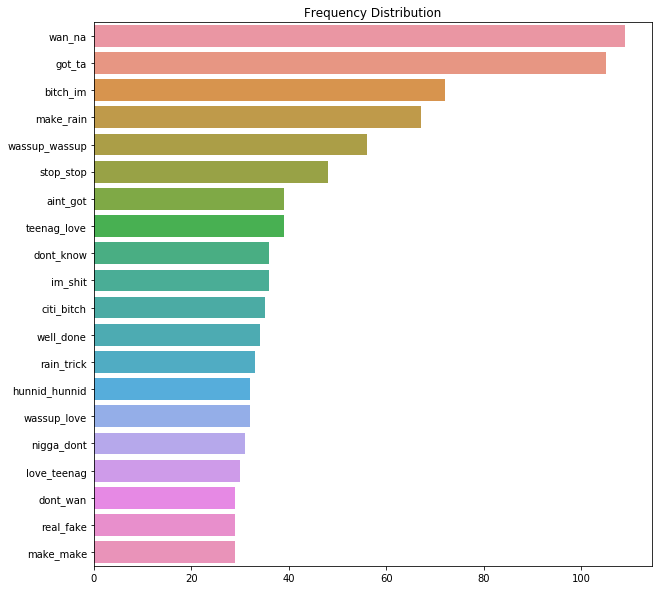

In [57]:
stemmed_bigrams = dlf.n_gram_creator(all_song_tokens_stemmed, counts=True)
stemmed_bigrams_joined = dlf.n_gram_plot_prepper(stemmed_bigrams, keep='join')
dlf.freqdist_plotter(stemmed_bigrams_joined, premade_fd=True, h_plot=True, n_common=20)

Top 20 Bi-grams by frequency


[(('wan', 'na'), 0.004016064257028112),
 (('got', 'ta'), 0.003868685752183044),
 (('bitch', 'im'), 0.0026528130872112304),
 (('make', 'rain'), 0.0024685899561548946),
 (('wassup', 'wassup'), 0.0020632990678309568),
 (('stop', 'stop'), 0.0017685420581408202),
 (('aint', 'got'), 0.0014369404222394164),
 (('teenag', 'love'), 0.0014369404222394164),
 (('dont', 'know'), 0.0013264065436056152),
 (('im', 'shit'), 0.0013264065436056152),
 (('citi', 'bitch'), 0.001289561917394348),
 (('well', 'done'), 0.0012527172911830809),
 (('rain', 'trick'), 0.001215872664971814),
 (('hunnid', 'hunnid'), 0.0011790280387605468),
 (('wassup', 'love'), 0.0011790280387605468),
 (('nigga', 'dont'), 0.0011421834125492796),
 (('love', 'teenag'), 0.0011053387863380127),
 (('dont', 'wan'), 0.0010684941601267455),
 (('make', 'make'), 0.0010684941601267455),
 (('real', 'fake'), 0.0010684941601267455)]

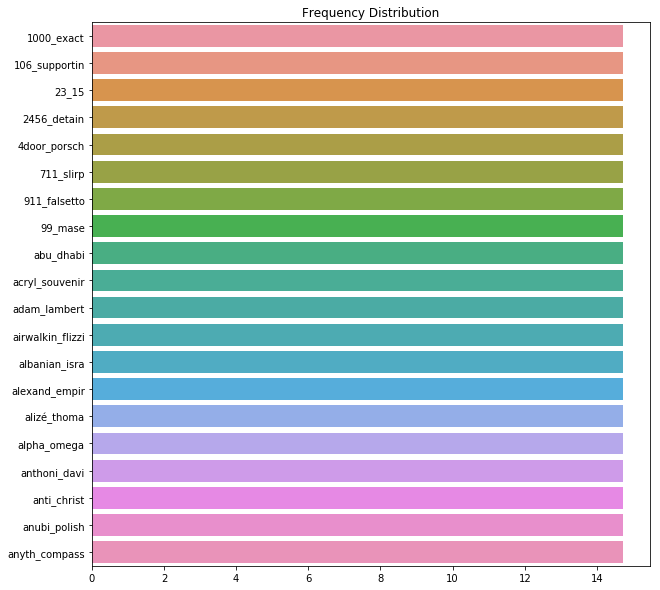

In [83]:
stemmed_bigrams_pmi = dlf.n_gram_creator(all_song_tokens_stemmed, keep='pmi')
stemmed_bigrams_pmi_joined = dlf.n_gram_plot_prepper(stemmed_bigrams_pmi, type_='pmi', keep='join')
dlf.freqdist_plotter(stemmed_bigrams_pmi_joined, premade_fd=True, h_plot=True, n_common=20)

Look into plotting negative values

##### Trigrams

In [19]:
token_stat_generator(all_song_tokens_stemmed, fd_plot=False, ngram=True, n=3, ngram_freq_filter=2, ngram_pmi=True)

Top 20 Tri-grams by frequency


[(('stop', 'stop', 'stop'), 0.0013264065436056152),
 (('make', 'rain', 'trick'), 0.001215872664971814),
 (('love', 'teenag', 'love'), 0.0011053387863380127),
 (('teenag', 'love', 'teenag'), 0.0011053387863380127),
 (('dont', 'wan', 'na'), 0.0010684941601267455),
 (('rack', 'citi', 'bitch'), 0.0009579602814929443),
 (('rain', 'trick', 'make'), 0.0009579602814929443),
 (('wassup', 'wassup', 'love'), 0.0008842710290704101),
 (('wassup', 'wassup', 'wassup'), 0.0008842710290704101),
 (('aint', 'got', 'ta'), 0.000847426402859143),
 (('im', 'make', 'rain'), 0.0008105817766478759),
 (('bitch', 'im', 'bitch'), 0.0007737371504366088),
 (('im', 'bitch', 'im'), 0.0007737371504366088),
 (('make', 'make', 'rain'), 0.0007000478980140746),
 (('ballin', 'ballin', 'ballin'), 0.0006632032718028076),
 (('got', 'ta', 'super'), 0.0006632032718028076),
 (('parti', 'parti', 'parti'), 0.0006632032718028076),
 (('ta', 'super', 'size'), 0.0006632032718028076),
 (('take', 'look', 'around'), 0.0006632032718028076)

PMI score for 20 Tri-grams


[(('trend', 'topic', 'hermè'), 27.456372513690017),
 (('urg', 'ultim', 'adult'), 27.456372513690017),
 (('biggi', 'pun', 'intend'), 26.87141001296886),
 (('pyramid', 'homicid', 'descript'), 26.87141001296886),
 (('forward', 'ford', 'escort'), 26.456372513690017),
 (('cum', 'flabbergastin', 'spazz'), 26.286447512247705),
 (('flabbergastin', 'spazz', 'spasm'), 26.286447512247705),
 (('mathemat', 'anim', 'dracula'), 26.286447512247705),
 (('zippin', 'dippin', 'jab'), 26.286447512247705),
 (('choo', 'train', 'oww'), 26.134444418802655),
 (('sin', 'jealous', 'attract'), 26.134444418802655),
 (('almost', 'est', '90'), 25.87141001296886),
 (('homicid', 'descript', 'hail'), 25.87141001296886),
 (('princess', 'promiscu', 'suppos'), 25.87141001296886),
 (('prone', 'lifestyl', 'tac'), 25.87141001296886),
 (('rosco', 'chicken', 'waffl'), 25.87141001296886),
 (('shouldnt', 'prone', 'lifestyl'), 25.87141001296886),
 (('anim', 'dracula', 'casket'), 25.701485011526547),
 (('skatin', 'basement', 'lone'

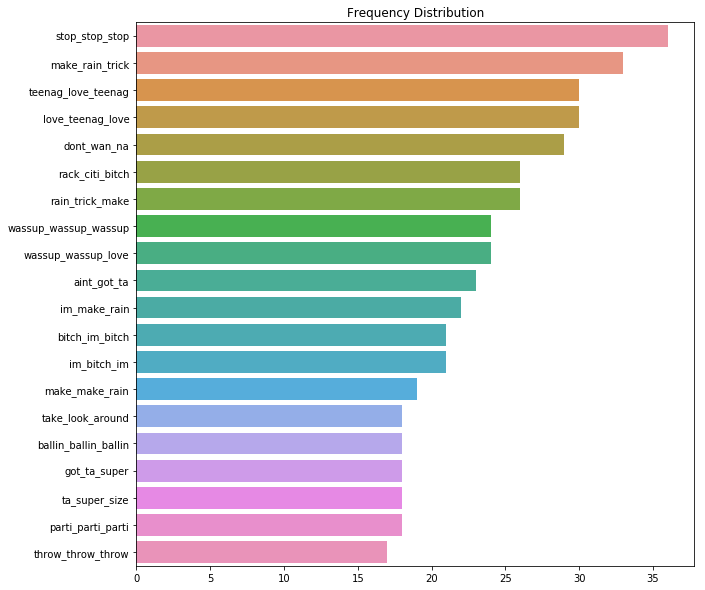

In [60]:
stemmed_trigrams = n_gram_creator(all_song_tokens_stemmed, n=3, counts=True)
stemmed_trigrams_joined = n_gram_plot_prepper(stemmed_trigrams, keep='join')
freqdist_plotter(stemmed_trigrams_joined, premade_fd=True, h_plot=True, n_common=20)

### Song Statistics

In [192]:
cleaned_lyrics_stats = dlf.song_stat_df_generator(cleaned_lyrics)
cleaned_lyrics_stats.head()

,title,total_words,unique_words,unique_total_ratio,avg_total,avg_unique,avg_unique_ratio
0,Do It All,561,190,0.338681,408.536364,181.272727,0.474921
1,Real Or Fake,437,192,0.439359,408.536364,181.272727,0.474921
2,LovaGain,356,131,0.367978,408.536364,181.272727,0.474921
3,Press 7,442,210,0.475113,408.536364,181.272727,0.474921
4,Day One,561,251,0.447415,408.536364,181.272727,0.474921


##### Song Length

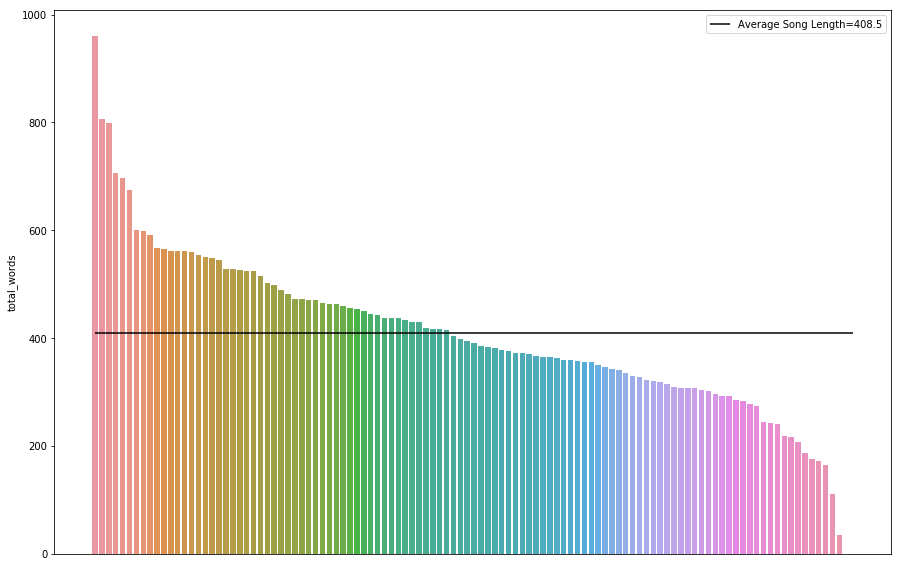

In [201]:
## Create Matplotlib figure + ax
fig, ax = plt.subplots(figsize=(15,10))

## Generate barplot sorted by song length
sns.barplot(cleaned_lyrics_stats.index, cleaned_lyrics_stats['total_words'].sort_values(ascending=False), ax=ax)

## Plot horizontal line representing average + xtick removal + legend display
plt.hlines(cleaned_lyrics_stats['avg_total'][0], xmin=0, xmax=len(cleaned_lyrics_stats), label=f"Average Song Length={round(cleaned_lyrics_stats['avg_total'][0], 1)}")
plt.xticks([])
plt.legend();

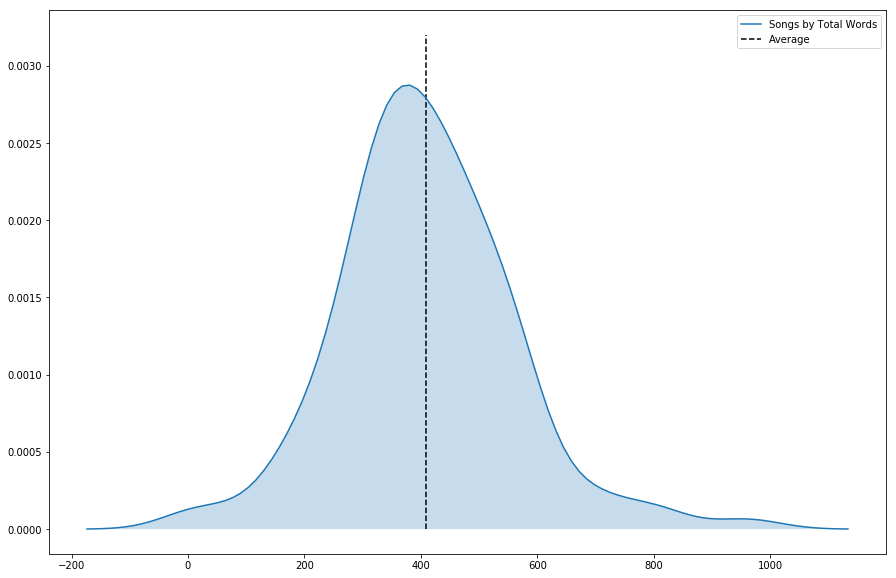

In [181]:
fig, ax = plt.subplots(figsize=(15,10))
sns.kdeplot(cleaned_lyrics_stats['total_words'], label='Songs by Total Words', shade=True, ax=ax)
plt.vlines(cleaned_lyrics_stats['avg_total'][0], 0, 0.0032, linestyles='dashed', label='Average')
plt.legend();

##### Unique Words

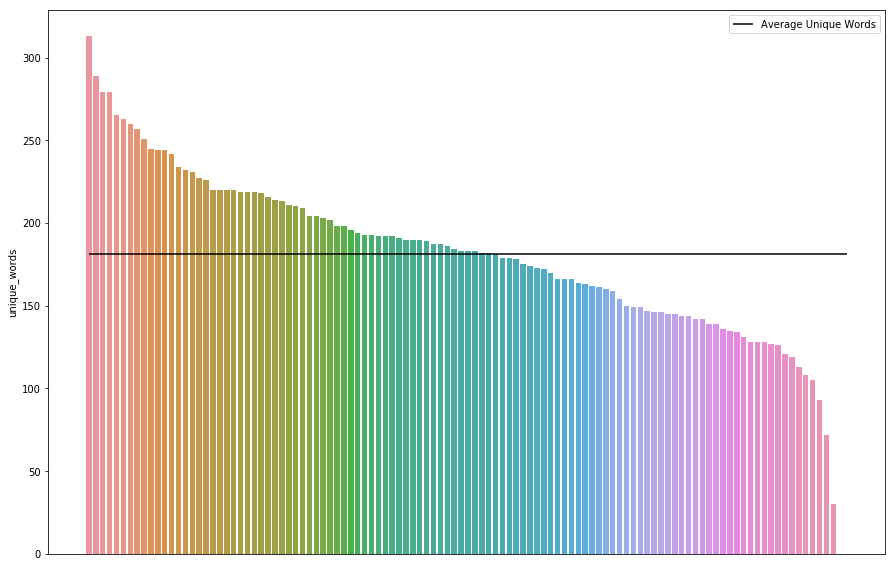

In [182]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(cleaned_lyrics_stats.index, cleaned_lyrics_stats['unique_words'].sort_values(ascending=False), ax=ax)
plt.hlines(cleaned_lyrics_stats['avg_unique'][0], xmin=0, xmax=len(cleaned_lyrics_stats), label='Average Unique Words')
plt.xticks([])
plt.legend();

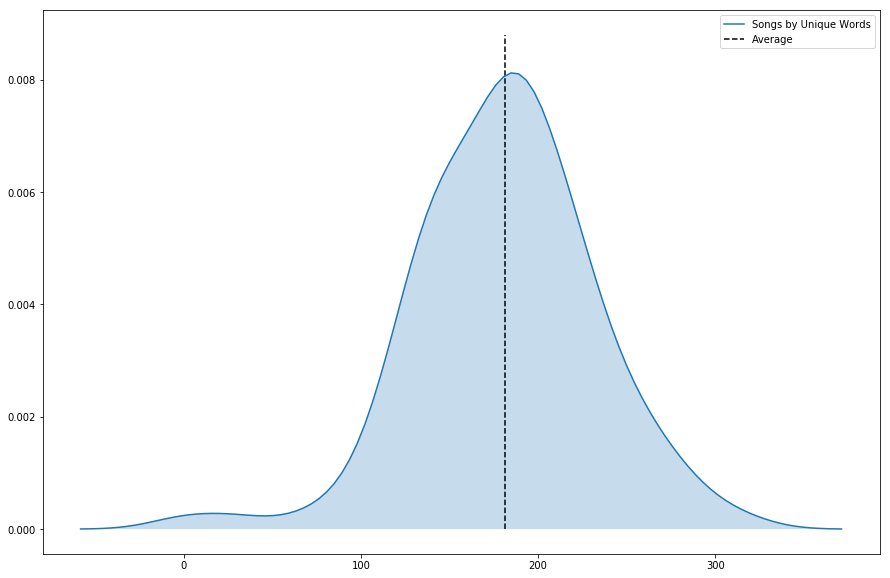

In [187]:
## Create Matplotlib figure + ax
fig, ax = plt.subplots(figsize=(15,10))

## Generate kdeplot
sns.kdeplot(cleaned_lyrics_stats['unique_words'], label='Songs by Unique Words', shade=True, ax=ax)

## Plot vertical line representing average + legend display
plt.vlines(cleaned_lyrics_stats['avg_unique'][0], 0, 0.0088, linestyles='dashed', label='Average')
plt.legend();

##### Unique to Total Ratio

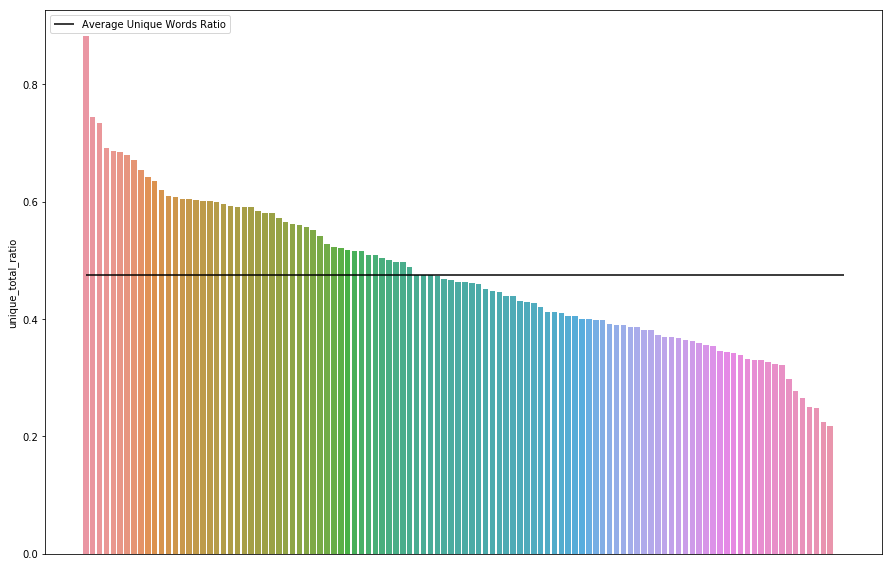

In [194]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(cleaned_lyrics_stats.index, cleaned_lyrics_stats['unique_total_ratio'].sort_values(ascending=False), ax=ax)
plt.hlines(cleaned_lyrics_stats['avg_unique_ratio'][0], xmin=0, xmax=len(cleaned_lyrics_stats), label='Average Unique Words Ratio')
plt.xticks([])
plt.legend();

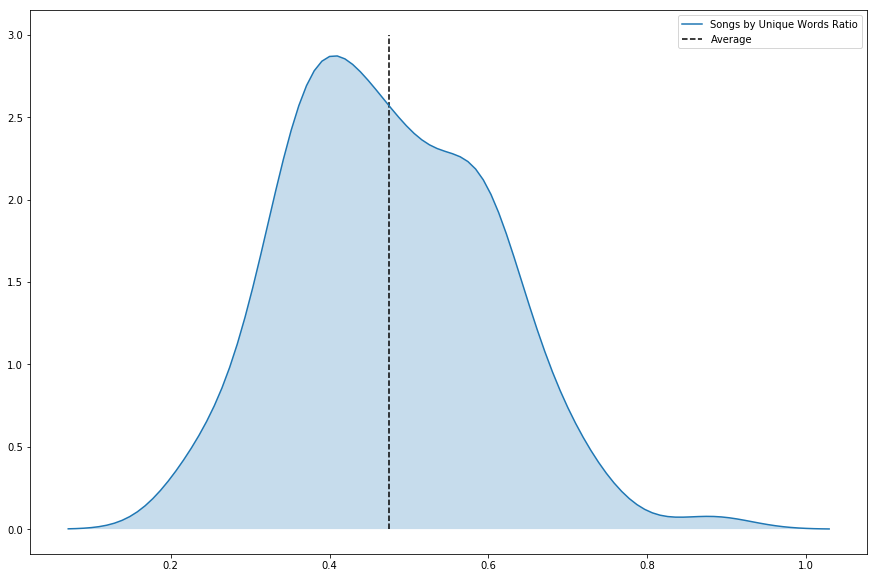

In [202]:
fig, ax = plt.subplots(figsize=(15,10))
sns.kdeplot(cleaned_lyrics_stats['unique_total_ratio'].dropna(inplace=False), label='Songs by Unique Words Ratio', shade=True, ax=ax)
plt.vlines(cleaned_lyrics_stats['avg_unique_ratio'][0], 0, 3, linestyles='dashed', label='Average')
plt.legend();

### Breaker

In [199]:
cleaned_lyrics['Do It All']

['looking at the ceiling thinking why i treat you bad',
 'aint no worser feelings than knowing i did it for the last',
 'arguing all i was doing accusing you my bad',
 'said lets take some time nevermind rewind',
 'looking at the ceiling thinking why i treat you bad',
 'aint no worser feelings than knowing i did it for the last',
 'arguing all i was doing accusing you my bad',
 'said lets take some time nevermind just playing with your mind',
 'i always thought play dumb and let the other one love',
 'why get caught up in nowhere but trust',
 'only love for fun im too young i thought',
 'all i wanted was a thanks to louboutins i bought',
 'but it aint your fault heaven knows you deserve it all',
 'you sent letters to my heart but i burned them all',
 'the bible says before you run gotta learn to crawl',
 'but i dont wanna waste time if we aint involved',
 'oh oh',
 'we been through it all',
 'i know i broke your heart once before',
 'but im done',
 'oh oh ohh',
 'tell me whats wrong',


12.12 **Plot out freq of bi-grams, plot out length per song, plot out unique words per song, pos tags**

12.9 **Stemming over Lemmatization** Just because Lemma-ing tokens will lose the actual word. Stemming will just shorten them

12.3 **Try these same graphs with stopwords removed.**

11.10 **NEED TO START HERE BY PULLING LIST OF FEATURES AND TRY TO MATCH UP WITH NAMES IN FEAT. PART**

Separate songs by feats or not.
* skip those with multi-results (for now)
* create list to match with from keys from lyric_header_checker

# Model Prep

### Creating Dataset

#### Creating Integer Lookups

In [3]:
## Merging cleaned lyrics into one string + pop string out of container
cleaned_lyrics_string = dlf.dict_string_concat(cleaned_lyrics)
cleaned_lyrics_string = cleaned_lyrics_string.pop()
vocab = sorted(set(cleaned_lyrics_string))

## Q.C.
print(f'There are {len(cleaned_lyrics_string):,} characters in the sample.')
print(f'{len(vocab)} of these characters are unique.\n')
print(f'First 200 characters:')
print(f'"{cleaned_lyrics_string[:200]}"')

************************************************************
109 strings pulled from dictionary
************************************************************
There are 221,150 characters in the sample.
41 of these characters are unique.

First 200 characters:
"looking at the ceiling thinking why i treat you bad
aint no worser feelings than knowing i did it for the last
arguing all i was doing accusing you my bad
said lets take some time nevermind rewind
loo"


In [4]:
## Each index will match value corresp. to character key in 'char_v_idx'
idx_v_char = np.array(vocab)
print('Index ==> Character lookup table:\n')
print(idx_v_char, '\n')
print('---'*30, '\n')

## Assigning characters to their index
print('Character ==> Index lookup table:\n')
char_v_idx = {c:i for i,c in enumerate(vocab)}
print(char_v_idx)

Index ==> Character lookup table:

['\n' ' ' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z' 'è' 'é' 'ó'] 

------------------------------------------------------------------------------------------ 

Character ==> Index lookup table:

{'\n': 0, ' ': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'è': 38, 'é': 39, 'ó': 40}


In [5]:
## Representing lyrics as integers
lyrics_as_int = np.array([char_v_idx[character] for character in cleaned_lyrics_string])

## Q.C.
print('Actual Lyrics:\n')
print(f'"{cleaned_lyrics_string[:22]}"', '\n')
print('---'*30, '\n')
print('Integer Representation:\n')
print(lyrics_as_int[:22])

Actual Lyrics:

"looking at the ceiling" 

------------------------------------------------------------------------------------------ 

Integer Representation:

[23 26 26 22 20 25 18  1 12 31  1 31 19 16  1 14 16 20 23 20 25 18]


#### Creating Sequences

In [6]:
## Selecting length of input sequences to be considered
seq_length = 10

## Q.C.
examples_per_epoch = len(cleaned_lyrics_string) // (seq_length + 1)
print(f'Examples per epoch: {examples_per_epoch:,}')

Examples per epoch: 20,104


In [7]:
## Creating dataset as scalar tensors
character_set = tf.data.Dataset.from_tensor_slices(lyrics_as_int)

## Q.C
print('Integers to characters:')
print('***'*20)

## Displaying in order int --> char
for i in character_set.take(10):
    int_rep = i.numpy()
    print(f'Int: {int_rep} --> {idx_v_char[int_rep]}')

Integers to characters:
************************************************************
Int: 23 --> l
Int: 26 --> o
Int: 26 --> o
Int: 22 --> k
Int: 20 --> i
Int: 25 --> n
Int: 18 --> g
Int: 1 -->  
Int: 12 --> a
Int: 31 --> t


In [8]:
## Creating 'seq_length' batches of lyrics
lyrics_sequenced = character_set.batch((seq_length + 1), drop_remainder=True)

## Q.C.
print('Integers to sequences:')
print('***'*20)

## Displaying batches
for i in lyrics_sequenced.take(2):
    print(i.numpy())
    print(''.join(idx_v_char[i.numpy()]), '\n')

Integers to sequences:
************************************************************
[23 26 26 22 20 25 18  1 12 31  1]
looking at  

[31 19 16  1 14 16 20 23 20 25 18]
the ceiling 



#### Inputs, Targets, & Training Batches

In [10]:
## Splitting inputs/targets + Q.C.
dataset_full = lyrics_sequenced.map(split_input_target)

for input_, target_ in dataset_full.take(1):
    print('Input:')
    print(input_.numpy(),'------>',''.join(idx_v_char[input_.numpy()]))
    print('Target:')
    print(target_.numpy(), '------>', ''.join(idx_v_char[target_.numpy()]))

Input:
[23 26 26 22 20 25 18  1 12 31] ------> looking at
Target:
[26 26 22 20 25 18  1 12 31  1] ------> ooking at 


In [11]:
for input_, target_ in dataset_full.take(1):
    
    for i, (input_ex, target_ex) in enumerate(zip(input_[:5], target_[:5])):
        print(f'Step {i}')
        print(f'  input: {input_ex} ({idx_v_char[input_ex]})')
        print(f'  expected output: {target_ex} ({idx_v_char[target_ex]})')
        print(10*'---')

Step 0
  input: 23 (l)
  expected output: 26 (o)
------------------------------
Step 1
  input: 26 (o)
  expected output: 26 (o)
------------------------------
Step 2
  input: 26 (o)
  expected output: 22 (k)
------------------------------
Step 3
  input: 22 (k)
  expected output: 20 (i)
------------------------------
Step 4
  input: 20 (i)
  expected output: 25 (n)
------------------------------


In [12]:
## Sequence batch size
batch_size = 64

## Buffer from which the next element is randomly selected during training
buffer_size = 1000

## Shuffling...
dataset_shuffled = dataset_full.shuffle(buffer_size, seed=810).batch(batch_size, drop_remainder=True)

### Building the Model

In [14]:
## Length of different characters in dataset
vocab_size = len(vocab)

## Dimenson of word embedding space
embed_dim = 256

## NO. RNN units for GRU layer
rnn_units = 1024

In [15]:
## Build it + Q.C.
model = build_model(vocab_size, embed_dim, rnn_units, batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           10496     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 41)            42025     
Total params: 3,990,825
Trainable params: 3,990,825
Non-trainable params: 0
_________________________________________________________________


### Pre-train Predictions

In [16]:
## Q.C. of prediction shape
for input_ex_batch, target_ex_batch in dataset_shuffled.take(1):
    ex_batch_preds = model(input_ex_batch)
    print(ex_batch_preds.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 10, 41) # (batch_size, sequence_length, vocab_size)


In [17]:
## Pull a single sequence of 10 predicted characters
sample_preds = tf.random.categorical(ex_batch_preds[3], num_samples=1)

## Augment shape (10, 1) --> (10,)
sample_preds = tf.squeeze(sample_preds, axis=-1).numpy()

## Q.C.
print('Sampled Prediction as int:')
display(sample_preds)

Sampled Prediction as int:


array([ 3, 21, 37, 27, 31, 14,  1,  9, 31, 26], dtype=int64)

In [18]:
## Testing untrained predictions as lyrics
print('Input: \n', ''.join(idx_v_char[input_ex_batch[3].numpy()]))
print()
print('Next Char Predictions: \n', ''.join(idx_v_char[sample_preds]))

Input: 
  or fake b

Next Char Predictions: 
 1jzptc 7to


### Training Prep

In [20]:
## Q.C. Pre-trained loss
ex_batch_loss = loss(target_ex_batch, ex_batch_preds)
print('Prediction shape: ', ex_batch_preds.shape, ' # (batch_size, sequence_length, vocab_size)')
print('Scalar_loss:      ', ex_batch_loss.numpy().mean())

Prediction shape:  (64, 10, 41)  # (batch_size, sequence_length, vocab_size)
Scalar_loss:       3.7136104


In [21]:
## Compile + select optimizer
model.compile(optimizer='adam', loss=loss)

In [22]:
## Setting checkpoints
## Directory where the checkpoints will be saved
chkpt_dir = './training_checkpoints'

# Name of the checkpoint files
chkpt_prefix = os.path.join(chkpt_dir, 'chkpt_{epoch}')

## Creating callback for model
chkpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=chkpt_prefix, save_weights_only=True)

### Model Training

In [23]:
## No. of epochs to train
epochs = 30

In [ ]:
## Instantiate timer
timer = dlf.Timer()

In [24]:
## Start!
timer.start()

## Train + stop timer when finished
history = model.fit(dataset_shuffled, epochs=epochs, callbacks=[chkpt_callback])
timer.stop()

Epoch 1/30
314/314 [==============================] - 65s 209ms/step - loss: 2.4170
Epoch 2/30
314/314 [==============================] - 65s 208ms/step - loss: 2.0197
Epoch 3/30
314/314 [==============================] - 65s 208ms/step - loss: 1.8963
Epoch 4/30
314/314 [==============================] - 65s 207ms/step - loss: 1.8184
Epoch 5/30
314/314 [==============================] - 65s 208ms/step - loss: 1.7570
Epoch 6/30
314/314 [==============================] - 65s 207ms/step - loss: 1.7052
Epoch 7/30
314/314 [==============================] - 65s 207ms/step - loss: 1.6603
Epoch 8/30
314/314 [==============================] - 65s 208ms/step - loss: 1.6179
Epoch 9/30
314/314 [==============================] - 65s 208ms/step - loss: 1.5838
Epoch 10/30
314/314 [==============================] - 65s 207ms/step - loss: 1.5490
Epoch 11/30
314/314 [==============================] - 65s 207ms/step - loss: 1.5186
Epoch 12/30
314/314 [==============================] - 65s 208ms/step - lo

# Text Generation

#### Model Build

In [12]:
## Directory where the checkpoints will be saved
chkpt_dir = './training_checkpoints'
## Collection of unique words in corpus
vocab = sorted(set(cleaned_lyrics_string))
## Length of different characters in dataset
vocab_size = len(vocab)
## Dimenson of word embedding space
embed_dim = 256
## NO. RNN units for GRU layer
rnn_units = 1024

In [13]:
## Checking checkpoint weights
print(tf.train.latest_checkpoint(chkpt_dir))

## New model for generation, loading weights + setting tensor shape for input
model_gen = build_model(vocab_size, embed_dim, rnn_units, batch_size=1)
model_gen.load_weights(tf.train.latest_checkpoint(chkpt_dir))
model_gen.build(tf.TensorShape([1, None]))
model_gen.summary()

./training_checkpoints\chkpt_30
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 256)            10496     
_________________________________________________________________
gru (GRU)                    (1, None, 1024)           3938304   
_________________________________________________________________
dense (Dense)                (1, None, 41)             42025     
Total params: 3,990,825
Trainable params: 3,990,825
Non-trainable params: 0
_________________________________________________________________


#### Time to Spit

In [29]:
print('Prediction Temperature 0.25:\n')
print(generate_text(model_gen, char_v_idx, idx_v_char, start_string='im like ', temp=0.25))
print('---'*20)
print('Prediction Temperature 0.5:\n')
print(generate_text(model_gen, char_v_idx, idx_v_char, start_string='im like ', temp=0.5))
print('---'*20)
print('Prediction Temperature 0.75:\n')
print(generate_text(model_gen, char_v_idx, idx_v_char, start_string='im like ', temp=0.75))
print('---'*20)
print('Prediction Temperature 1.0:\n')
print(generate_text(model_gen char_v_idx, idx_v_char, start_string='im like ', temp=1.0))
print('---'*20)

Prediction Temperature 0.25:

im like this is not a diss song
they just got that beef
diss song
they just got that beef
dont play this son
------------------------------------------------------------
Prediction Temperature 0.5:

im like that beef like the percenters right
when you see me in the sky
walk ut that nigga
watch my check
tel
------------------------------------------------------------
Prediction Temperature 0.75:

im like this
woww
ever here party party over here party over here party over here sup wassup its all love
wa
------------------------------------------------------------
Prediction Temperature 1.0:

im like this s need a lap dance
be moving benk o purp your faith in my chucks around like that
can before wv
------------------------------------------------------------


# Using All Songs

#### Filter, Merge, & Clean

In [7]:
## Filtering + conversion to str
filtered_lyrics_fts = dlf.lyric_header_filter(song_dict, [], display_multi=False)

## Merging lyrics
merged_lyrics_fts = dlf.lyric_line_splitter(filtered_lyrics_fts)

## Cleaning punctuation/headers + lowering strings + Q.C.
cleaned_lyrics_fts = dlf.song_cleaner(merged_lyrics_fts)

In [103]:
## Merging cleaned lyrics into one string + pop string out of container
cleaned_lyrics_string_fts = dlf.dict_string_concat(cleaned_lyrics_fts)
cleaned_lyrics_string_fts = cleaned_lyrics_string_fts.pop()
vocab_fts = sorted(set(cleaned_lyrics_string_fts))

## Q.C.
print(f'There are {len(cleaned_lyrics_string_fts):,} characters in the sample.')
print(f'{len(vocab_fts)} of these characters are unique.\n')

************************************************************
181 strings pulled from dictionary
************************************************************
There are 412,330 characters in the sample.
42 of these characters are unique.



#### Lookup Tables & Sequencing

In [9]:
## Each index will match value corresp. to character key in 'char_v_idx'
idx_v_char_fts = np.array(vocab_fts)
print('Index ==> Character lookup table:\n')
print(idx_v_char_fts, '\n')
print('---'*30, '\n')

## Assigning characters to their index
print('Character ==> Index lookup table:\n')
char_v_idx_fts = {c:i for i,c in enumerate(vocab_fts)}
print(char_v_idx_fts)

## Representing lyrics as integers
lyrics_as_int_fts = np.array([char_v_idx_fts[character] for character in cleaned_lyrics_string_fts])

Index ==> Character lookup table:

['\n' ' ' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z' 'è' 'é' 'ë' 'ó'] 

------------------------------------------------------------------------------------------ 

Character ==> Index lookup table:

{'\n': 0, ' ': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, 'è': 38, 'é': 39, 'ë': 40, 'ó': 41}


In [10]:
## Selecting length of input sequences to be considered
seq_length_fts = 50

## Creating dataset as scalar tensors
character_set_fts = tf.data.Dataset.from_tensor_slices(lyrics_as_int_fts)

## Creating 'seq_length' batches of lyrics
lyrics_sequenced_fts = character_set_fts.batch((seq_length_fts + 1), drop_remainder=True)

## Splitting inputs/targets
dataset_full_fts = lyrics_sequenced_fts.map(split_input_target)

#### Batch, Shuffle, & Build

In [11]:
## Sequence batch size
batch_size_fts = 64

## Buffer from which the next element is randomly selected during training
buffer_size_fts = 1000

## Shuffling...
dataset_shuffled_fts = dataset_full_fts.shuffle(buffer_size_fts, seed=810).batch(batch_size_fts, drop_remainder=True)

In [12]:
## Length of different characters in dataset
vocab_size_fts = len(vocab_fts)

## Dimenson of word embedding space
embed_dim_fts = 256

## NO. RNN units for GRU layer
rnn_units_fts = 1024

## Build it + Q.C.
model_fts = build_model(vocab_size_fts, embed_dim_fts, rnn_units_fts, batch_size_fts)
print(model_fts.summary())

## Compile + select optimizer
model_fts.compile(optimizer='adam', loss=loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           10752     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 42)            43050     
Total params: 3,992,106
Trainable params: 3,992,106
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
## Setting checkpoints
## Directory where the checkpoints will be saved
chkpt_dir_fts = './training_checkpoints_all_songs'

# Name of the checkpoint files
chkpt_prefix_fts = os.path.join(chkpt_dir_fts, 'chkpt_{epoch}')

## Creating callback for model
chkpt_callback_fts = tf.keras.callbacks.ModelCheckpoint(filepath=chkpt_prefix_fts, save_weights_only=True)

#### Training

In [33]:
## No. of epochs to train [35 completed]
epochs = 5

In [15]:
## Instantiate timer
timer_fts = dlf.Timer()

In [37]:
## Start!
timer_fts.start()

## Train + stop timer when finished
history_fts = model_fts.fit(dataset_shuffled_fts, epochs=epochs, callbacks=[chkpt_callback_fts])
timer_fts.stop()

Epoch 1/5
126/126 [==============================] - 119s 946ms/step - loss: 0.4969
Epoch 2/5
126/126 [==============================] - 120s 949ms/step - loss: 0.4913
Epoch 3/5
126/126 [==============================] - 120s 949ms/step - loss: 0.4885
Epoch 4/5
126/126 [==============================] - 121s 959ms/step - loss: 0.4862
Epoch 5/5
126/126 [==============================] - 119s 947ms/step - loss: 0.4802
---- Timer stopped at: 12/23/2020 - 04:28 PM ----
---- Time elasped: 0:10:04.510754 ----


#### Text Generation

In [38]:
## Checking checkpoint
print(tf.train.latest_checkpoint(chkpt_dir_fts))

## New model for generation, loading weights + setting tensor shape for input
model_gen_fts = build_model(vocab_size_fts, embed_dim_fts, rnn_units_fts, batch_size=1)
model_gen_fts.load_weights(tf.train.latest_checkpoint(chkpt_dir_fts))
model_gen_fts.build(tf.TensorShape([1, None]))
model_gen_fts.summary()

./training_checkpoints_all_songs\chkpt_5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            10752     
_________________________________________________________________
gru_3 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_3 (Dense)              (1, None, 42)             43050     
Total params: 3,992,106
Trainable params: 3,992,106
Non-trainable params: 0
_________________________________________________________________


In [40]:
print('Prediction Temperature 0.25:\n')
print(generate_text(model_gen_fts, char_v_idx_fts, idx_v_char_fts, start_string='im like ', temp=0.25))
print('---'*20)
print('Prediction Temperature 0.5:\n')
print(generate_text(model_gen_fts, char_v_idx_fts, idx_v_char_fts, start_string='im like ', temp=0.5))
print('---'*20)
print('Prediction Temperature 0.75:\n')
print(generate_text(model_gen_fts, char_v_idx_fts, idx_v_char_fts, start_string='im like ', temp=0.75))
print('---'*20)
print('Prediction Temperature 1.0:\n')
print(generate_text(model_gen_fts, char_v_idx_fts, idx_v_char_fts, start_string='im like ', temp=1.0))
print('---'*20)

Prediction Temperature 0.25:

im like a dont do and we wanna welcome all ya 2 fan of a fan nigga its crody you aint gotta hate
wassup wass
------------------------------------------------------------
Prediction Temperature 0.5:

im like a dentin in ya face no more
no more no more no more no more no more no more no more no more no more 
------------------------------------------------------------
Prediction Temperature 0.75:

im like a ddub
bitch straight up got a taser for my bitch
i dont give them
names jane down in the bank proba
------------------------------------------------------------
Prediction Temperature 1.0:

im like a drum
real nigga bitches know my back round
bring me oh oh hundreds hundreds the sound
world around
------------------------------------------------------------


In [46]:
print('Prediction Temperature 0.25:\n')
print(generate_text(model_gen_fts, char_v_idx_fts, idx_v_char_fts, start_string='red', temp=0.25))
print('---'*20)
print('Prediction Temperature 0.5:\n')
print(generate_text(model_gen_fts, char_v_idx_fts, idx_v_char_fts, start_string='red', temp=0.5))
print('---'*20)
print('Prediction Temperature 0.75:\n')
print(generate_text(model_gen_fts, char_v_idx_fts, idx_v_char_fts, start_string='red', temp=0.75))
print('---'*20)
print('Prediction Temperature 1.0:\n')
print(generate_text(model_gen_fts, char_v_idx_fts, idx_v_char_fts, start_string='red', temp=1.0))
print('---'*20)

Prediction Temperature 0.25:

red brain cheap its like pissol
if we got a problem yeah all my niggas do the stadiame
these niggas the
------------------------------------------------------------
Prediction Temperature 0.5:

red too many niggas hating bad to this song
oh man
i promise we gon do it til the sun come down
i swear
------------------------------------------------------------
Prediction Temperature 0.75:

red like a sper back out
i know shit ask super fast
im a had this no niggas aint shell t the pussy face
------------------------------------------------------------
Prediction Temperature 1.0:

red in this ping put only be who dat see you in hell
and your bitch who than new sof shit that im close
------------------------------------------------------------


# Censorship

Instead of preprocessing the data using the `Censor()`, I will generate predictions using the lyrics as intended. Then, I will run the predictions through the `Censor()` after capturing the string output and tokenizing it. This will allow my model to maintain the info from the "bad" words while still producing friendly lyrics.

#### Lyric Prep

In [8]:
## Tokenize all songs + Q.C.
tokenized_lyrics_fts = dlf.lyric_tokenizer(cleaned_lyrics_fts)
tokenized_lyrics_fts['Heisman (feat. Honey Cocaine)'][0:10]

['bitch',
 'im',
 'honey',
 'cocaine',
 'bout',
 'to',
 'bring',
 'in',
 'some',
 'pain']

In [9]:
## Results container
all_song_tokens_fts = []

## Adding to container song-by-song
for song in tokenized_lyrics_fts:
    all_song_tokens_fts.extend(tokenized_lyrics_fts[song])

print(f'Total tokens: {len(all_song_tokens_fts):,}')
print(f'Total unique tokens: {len(set(all_song_tokens_fts)):,}')

Total tokens: 84,816
Total unique tokens: 7,243


## Examples

### Known Lyrics

In [111]:
test_censor = dlf.Censor(tokenized_lyrics_fts['Heisman (feat. Honey Cocaine)'])

In [112]:
test_censor.create_set(show=True)
test_censor.find_targets()
test_censor.count_targets(show=True)

Total tokens: 365
Total unique tokens: 203


{'bitch': 5, 'nigga': 5, 'fuck': 4, 'shit': 3, 'bitches': 1, 'niggas': 1}

In [113]:
test_censor._targeted

['fuck', 'bitch', 'bitches', 'shit', 'nigga', 'niggas']

In [114]:
# test_censor.alter_targets(['ARSE', 'FLUTE', 'FLUTING', 'BENCH', 'PITHY', 'SHED', 'NINER'])
test_censor.mute_targets()
# test_censor.remove_targets()

In [116]:
display(test_censor.add_target('horny'))
display(test_censor.count_targets('M', True))
display(test_censor._targeted)
test_censor.mute_targets()

None

{}

['fuck', 'bitch', 'bitches', 'shit', 'nigga', 'niggas', 'horny']

In [117]:
test_censor.get_lyrics('M')

['b***h',
 'im',
 'honey',
 'cocaine',
 'bout',
 'to',
 'bring',
 'in',
 'some',
 'pain',
 'all',
 'my',
 'haters',
 'like',
 'a',
 'choir',
 'they',
 'all',
 'singing',
 'my',
 'name',
 'aint',
 'got',
 'a',
 'heart',
 'for',
 'a',
 'broad',
 'thats',
 'the',
 'rule',
 'of',
 'the',
 'game',
 'now',
 'you',
 'a',
 'fool',
 'if',
 'you',
 'aim',
 'ill',
 'put',
 'a',
 'tool',
 'to',
 'ya',
 'brain',
 'im',
 'bout',
 'to',
 'get',
 'it',
 'then',
 'spend',
 'it',
 'if',
 'i',
 'said',
 'it',
 'i',
 'meant',
 'it',
 'f**k',
 'your',
 'feelings',
 'taste',
 'my',
 'weapons',
 'act',
 'like',
 'a',
 'b***h',
 'ill',
 'erase',
 'yo',
 'blessings',
 'yo',
 'you',
 'are',
 'not',
 'familiar',
 'with',
 'me',
 'if',
 'you',
 'comic',
 'in',
 'a',
 'move',
 'b***h',
 'your',
 'visitor',
 'is',
 'me',
 'ahh',
 'its',
 'that',
 'drop',
 'top',
 'phantom',
 'chop',
 'all',
 'gold',
 'rolly',
 'tock',
 'f**k',
 'yo',
 'fans',
 'f**k',
 'a',
 'cop',
 'all',
 'my',
 'b*****s',
 'betty',
 'bops',
 'be

In [118]:
test_censor.get_word_counts('M')

{'you': 16,
 'a': 11,
 'yo': 11,
 'me': 10,
 'my': 8,
 'i': 8,
 'im': 7,
 'like': 7,
 'the': 7,
 'just': 6,
 'b***h': 5,
 'to': 5,
 'in': 5,
 'all': 5,
 'it': 5,
 'n***a': 5,
 'bout': 4,
 'for': 4,
 'now': 4,
 'if': 4,
 'f**k': 4,
 'your': 4,
 'some': 3,
 'aint': 3,
 'that': 3,
 's**t': 3,
 'dont': 3,
 'around': 3,
 'and': 3,
 'be': 3,
 'gone': 3,
 'they': 2,
 'of': 2,
 'game': 2,
 'aim': 2,
 'ill': 2,
 'brain': 2,
 'act': 2,
 'move': 2,
 'betty': 2,
 'know': 2,
 'need': 2,
 'auugh': 2,
 'on': 2,
 'give': 2,
 'at': 2,
 'cause': 2,
 'man': 2,
 'lie': 2,
 'money': 2,
 'middle': 2,
 'young': 2,
 'honey': 1,
 'cocaine': 1,
 'bring': 1,
 'pain': 1,
 'haters': 1,
 'choir': 1,
 'singing': 1,
 'name': 1,
 'got': 1,
 'heart': 1,
 'broad': 1,
 'thats': 1,
 'rule': 1,
 'fool': 1,
 'put': 1,
 'tool': 1,
 'ya': 1,
 'get': 1,
 'then': 1,
 'spend': 1,
 'said': 1,
 'meant': 1,
 'feelings': 1,
 'taste': 1,
 'weapons': 1,
 'erase': 1,
 'blessings': 1,
 'are': 1,
 'not': 1,
 'familiar': 1,
 'with': 1,
 '

### Generated Lyrics

#### Creating the Model

In [6]:
## Directory where the checkpoints will be saved
chkpt_dir_fts = './training_checkpoints_all_songs'
## Collection of unique words in corpus
vocab_fts = sorted(set(cleaned_lyrics_string_fts))
## Each index will match value corresp. to character key in 'char_v_idx'
idx_v_char_fts = np.array(vocab_fts)
## Assigning characters to their index
char_v_idx_fts = {c:i for i,c in enumerate(vocab_fts)}
## Length of different characters in dataset
vocab_size_fts = len(vocab_fts)
## Dimenson of word embedding space
embed_dim_fts = 256
## NO. RNN units for GRU layer
rnn_units_fts = 1024

In [24]:
## Checking checkpoint
print(tf.train.latest_checkpoint(chkpt_dir_fts))

## New model for generation, loading weights + setting tensor shape for input
model_gen_fts = build_model(vocab_size_fts, embed_dim_fts, rnn_units_fts, batch_size=1)
model_gen_fts.load_weights(tf.train.latest_checkpoint(chkpt_dir_fts))
model_gen_fts.build(tf.TensorShape([1, None]))
model_gen_fts.summary()

./training_checkpoints_all_songs\chkpt_5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            10752     
_________________________________________________________________
gru_2 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_2 (Dense)              (1, None, 42)             43050     
Total params: 3,992,106
Trainable params: 3,992,106
Non-trainable params: 0
_________________________________________________________________


#### Generate + Censor

In [258]:
## Instantiate generator class
txt_gen = dlf.TextGenerator(model_gen_fts, idx_v_char_fts, char_v_idx_fts)
## Create new text based upon input string + store it
txt_gen.generate_text('Im number one\n', 200, .75)
new_lyrics = txt_gen.get_generated_text()

In [259]:
## Instantiate censor class
txt_censor = dlf.Censor(new_lyrics)
## Split string into tokens
txt_censor.str_splitter()
## Mute censorable words with *s
txt_censor.execute_censoring()
## Join tokens into a string
txt_censor.str_joiner('M')
## Store and display new lyrics
censored_lyrics = txt_censor.get_lyrics('J')

In [260]:
## Check of new lyrics
print('***'*20)
print('Original Lyrics:')
print('***'*20)
print(new_lyrics)
print('***'*20)
print('Original Lyrics:')
print('***'*20)
print(censored_lyrics)

************************************************************
Original Lyrics:
************************************************************
Im number one
caper a bitch name aint dirt
walkin through the streets wearin jewels
gonna fuck up and bust young niggas with tools
and turn snitch when you see em
they aint talkin bout shit
westside
i keep a vest o
************************************************************
Original Lyrics:
************************************************************
Im number one
caper a b***h name aint dirt
walkin through the streets wearin jewels
gonna f**k up and bust young n****s with tools
and turn snitch when you see em
they aint talkin bout s**t
westside
i keep a vest 


Check Here! [By character generation](https://www.tensorflow.org/tutorials/text/text_generation) or Here! [By word generation](https://keras.io/examples/generative/text_generation_with_miniature_gpt/)